## 1. Установка и импорт библиотек

In [1]:
!pip -q install medmnist torch torchvision scikit-learn scikit-image matplotlib pandas ipywidgets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medmnist import INFO, BloodMNIST
from torchvision import transforms

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from skimage.feature import hog


## 2. Загрузка и описание набора данных

### 2.1 Загрузка датасета BloodMNIST

In [3]:
data_flag = "bloodmnist"
info = INFO[data_flag]
label_map = info["label"]
n_classes = len(label_map)

transform = transforms.Compose([transforms.ToTensor()])

train_ds = BloodMNIST(split="train", transform=transform, download=True)
val_ds   = BloodMNIST(split="val",   transform=transform, download=True)
test_ds  = BloodMNIST(split="test",  transform=transform, download=True)

print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))
print("Classes:", n_classes)
print("Labels:", label_map)


Train/Val/Test: 11959 1712 3421
Classes: 8
Labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### 2.2 Формирование массивов меток классов и анализ распределения классов

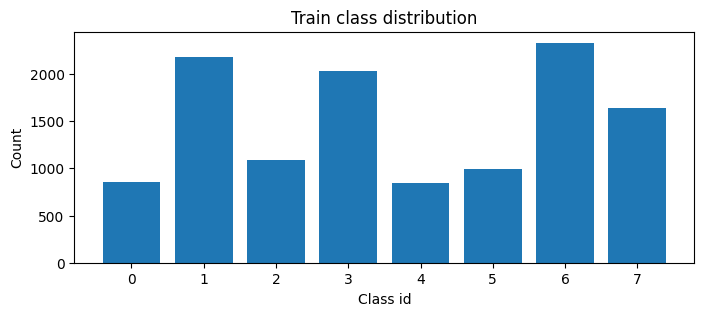

In [4]:
def get_labels(ds):
    ys = []
    for i in range(len(ds)):
        _, y = ds[i]
        ys.append(int(y.item()))
    return np.array(ys)

y_train = get_labels(train_ds)
y_val   = get_labels(val_ds)
y_test  = get_labels(test_ds)

def plot_class_counts(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    plt.figure(figsize=(8,3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel("Class id")
    plt.ylabel("Count")
    plt.show()
    return counts

train_counts = plot_class_counts(y_train, "Train class distribution")


Номера классов соответствуют следующим типам клеток крови:
- 0 — basophil  
- 1 — eosinophil  
- 2 — erythroblast  
- 3 — immature granulocytes  
- 4 — lymphocyte  
- 5 — monocyte  
- 6 — neutrophil  
- 7 — platelet

### 2.3 Визуализация примеров изображений из обучающей выборки

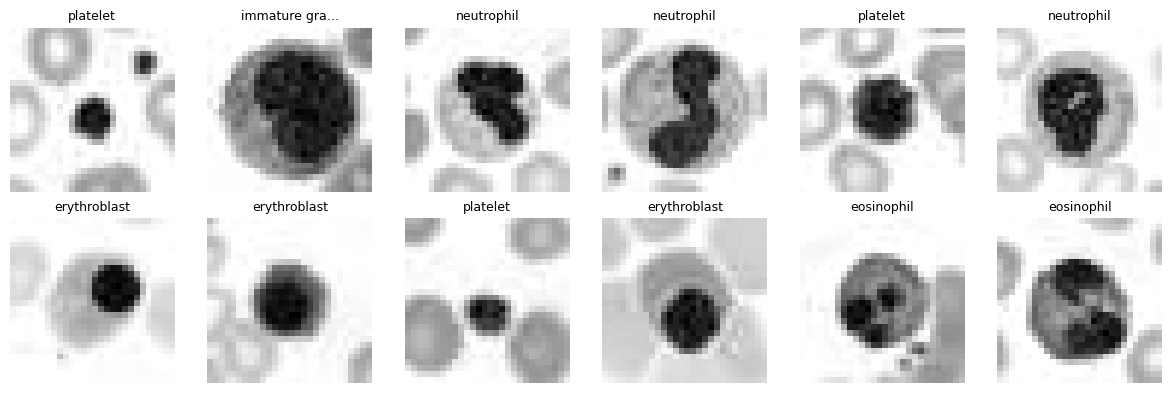

In [5]:
def show_samples_pretty(ds, k=12, max_len=12):
    cols = k // 2
    plt.figure(figsize=(12,4))
    for i in range(k):
        x, y = ds[i]
        img = x[0].numpy()
        label_id = int(y.item())
        name = label_map[str(label_id)]
        name = (name[:max_len] + "…") if len(name) > max_len else name

        ax = plt.subplot(2, cols, i+1)
        ax.imshow(img, cmap="gray")
        ax.set_title(name, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_samples_pretty(train_ds, 12)

### 2.4 Преобразование датасета в массивы NumPy

In [6]:
def ds_to_numpy(ds):
    X, y = [], []
    for i in range(len(ds)):
        x_t, y_t = ds[i] 
        X.append(x_t[0].numpy())  
        y.append(int(y_t.item())) 
    return np.stack(X), np.array(y)

Xtr_img, ytr = ds_to_numpy(train_ds)
Xva_img, yva = ds_to_numpy(val_ds)
Xte_img, yte = ds_to_numpy(test_ds)

print(Xtr_img.shape, ytr.shape)


(11959, 28, 28) (11959,)


## 3. Методы классификации изображений

### 3.1. Извлечение HOG-признаков из изображений

In [7]:
def hog_features(X_imgs):
    feats = []
    for img in X_imgs:
        f = hog(img, pixels_per_cell=(4,4), cells_per_block=(2,2), orientations=9, feature_vector=True)
        feats.append(f)
    return np.stack(feats)

Xtr_hog = hog_features(Xtr_img)
Xva_hog = hog_features(Xva_img)
Xte_hog = hog_features(Xte_img)

print("HOG feature size:", Xtr_hog.shape[1])


HOG feature size: 1296


### 3.2 Классификация изображений с использованием метода k ближайших соседей (kNN)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# SVM + HOG
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=5, gamma="scale"))
])

# обучение
svm.fit(Xtr_hog, ytr)

# проверка на val
pred_va = svm.predict(Xva_hog)

print("SVM val accuracy:", accuracy_score(yva, pred_va))
print("SVM val macro-F1:", f1_score(yva, pred_va, average="macro"))


SVM val accuracy: 0.7949766355140186
SVM val macro-F1: 0.7766086440415443


#### Подбор оптимального значения параметра k для алгоритма kNN

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np

Xtr_flat = Xtr_img.reshape(len(Xtr_img), -1)
Xva_flat = Xva_img.reshape(len(Xva_img), -1)
Xte_flat = Xte_img.reshape(len(Xte_img), -1)

ks = [1, 3, 5, 7, 9, 11, 15, 21]

rows = []
best_k = None
best_f1 = -1.0

for k in ks:
    model_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=k))
    ])
    model_knn.fit(Xtr_flat, ytr)
    pred_val = model_knn.predict(Xva_flat)

    acc = accuracy_score(yva, pred_val)
    f1  = f1_score(yva, pred_val, average="macro")

    rows.append({"k": k, "val_accuracy": acc, "val_macro_f1": f1})

    if f1 > best_f1:
        best_f1 = f1
        best_k = k

results_knn = pd.DataFrame(rows).sort_values("val_macro_f1", ascending=False).reset_index(drop=True)
display(results_knn)

print(f"Best k by val_macro_f1: k={best_k}, val_macro_f1={best_f1:.4f}")

knn_best = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=best_k))
])
knn_best.fit(Xtr_flat, ytr)

pred_val_best = knn_best.predict(Xva_flat)
print("Best kNN val accuracy:", accuracy_score(yva, pred_val_best))
print("Best kNN val macro-F1:", f1_score(yva, pred_val_best, average="macro"))



,k,val_accuracy,val_macro_f1
0,21,0.674065,0.661259
1,15,0.669393,0.656322
2,11,0.660047,0.649310
3,7,0.648949,0.644001
4,9,0.650701,0.641851
5,5,0.642523,0.633768
6,3,0.618575,0.612230
7,1,0.578271,0.566399


Best k by val_macro_f1: k=21, val_macro_f1=0.6613
Best kNN val accuracy: 0.6740654205607477
Best kNN val macro-F1: 0.6612585678253591


### 3.3 Сверточная нейронная сеть (CNN)

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 28->14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 14->7
            nn.Flatten(),
            nn.Linear(32*7*7, 128), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleCNN(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def eval_loader(model, loader):
    model.eval()
    all_pred, all_y = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.squeeze().long().to(device)
            logits = model(x)
            pred = torch.argmax(logits, dim=1)
            all_pred.append(pred.cpu().numpy())
            all_y.append(y.cpu().numpy())
    yp = np.concatenate(all_pred)
    yt = np.concatenate(all_y)
    return accuracy_score(yt, yp), f1_score(yt, yp, average="macro")

best_val = -1
best_state = None

for epoch in range(1, 16):
    model.train()
    losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.squeeze().long().to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    val_acc, val_f1 = eval_loader(model, val_loader)
    print(f"Epoch {epoch}: loss={np.mean(losses):.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}")

    if val_f1 > best_val:
        best_val = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

model.load_state_dict(best_state)
print("Best val macro-F1:", best_val)


Device: cpu
Epoch 1: loss=1.5167 val_acc=0.6098 val_f1=0.5218
Epoch 2: loss=0.9480 val_acc=0.6741 val_f1=0.6319
Epoch 3: loss=0.8138 val_acc=0.7442 val_f1=0.6724
Epoch 4: loss=0.7321 val_acc=0.7629 val_f1=0.7048
Epoch 5: loss=0.6588 val_acc=0.7985 val_f1=0.7611
Epoch 6: loss=0.6208 val_acc=0.8172 val_f1=0.7846
Epoch 7: loss=0.5687 val_acc=0.8107 val_f1=0.7711
Epoch 8: loss=0.5365 val_acc=0.8294 val_f1=0.7964
Epoch 9: loss=0.4976 val_acc=0.8248 val_f1=0.7914
Epoch 10: loss=0.4667 val_acc=0.8575 val_f1=0.8357
Epoch 11: loss=0.4536 val_acc=0.8493 val_f1=0.8196
Epoch 12: loss=0.4287 val_acc=0.8581 val_f1=0.8345
Epoch 13: loss=0.4231 val_acc=0.8610 val_f1=0.8395
Epoch 14: loss=0.3946 val_acc=0.8721 val_f1=0.8515
Epoch 15: loss=0.3941 val_acc=0.8832 val_f1=0.8661
Best val macro-F1: 0.8660846350648349


## 4. Сравнение методов классификации на тестовой выборке

In [11]:
# SVM test
svm_pred = svm.predict(Xte_hog)
svm_acc = accuracy_score(yte, svm_pred)
svm_f1  = f1_score(yte, svm_pred, average="macro")

# kNN test 
knn_pred = knn_best.predict(Xte_flat)
knn_acc = accuracy_score(yte, knn_pred)
knn_f1  = f1_score(yte, knn_pred, average="macro")

# CNN test
cnn_acc, cnn_f1 = eval_loader(model, test_loader)

results = pd.DataFrame([
    {"model": "HOG + SVM", "test_accuracy": svm_acc, "test_macro_f1": svm_f1},
    {"model": "Flatten + kNN", "test_accuracy": knn_acc, "test_macro_f1": knn_f1},
    {"model": "CNN (PyTorch)", "test_accuracy": cnn_acc, "test_macro_f1": cnn_f1},
]).sort_values("test_macro_f1", ascending=False)

results


,model,test_accuracy,test_macro_f1
2,CNN (PyTorch),0.871090,0.848899
0,HOG + SVM,0.785443,0.762815
1,Flatten + kNN,0.678164,0.665458


## Сохранение обученных моделей

In [12]:
import joblib, torch, json

joblib.dump(svm, "svm_hog.pkl")
joblib.dump(knn_best, "knn_best.pkl")

torch.save(model.state_dict(), "cnn.pt")

with open("label_map.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("Saved: svm_hog.pkl, knn_best.pkl, cnn.pt, label_map.json")


Saved: svm_hog.pkl, knn_best.pkl, cnn.pt, label_map.json


In [13]:
%pip install -U python-telegram-bot==21.6 pillow scikit-image joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
